In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
# Set plot style for publication quality
sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (14, 10), 'font.size': 16})

plt.rc('font', family='serif')
#plt.rc('xtick', labelsize='large')
#plt.rc('ytick', labelsize='large')

# Load the AirPassengers dataset
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', parse_dates=['Month'], index_col='Month')
# Decompose the time series to identify trend and seasonal components
result = seasonal_decompose(data['Passengers'], model='additive')



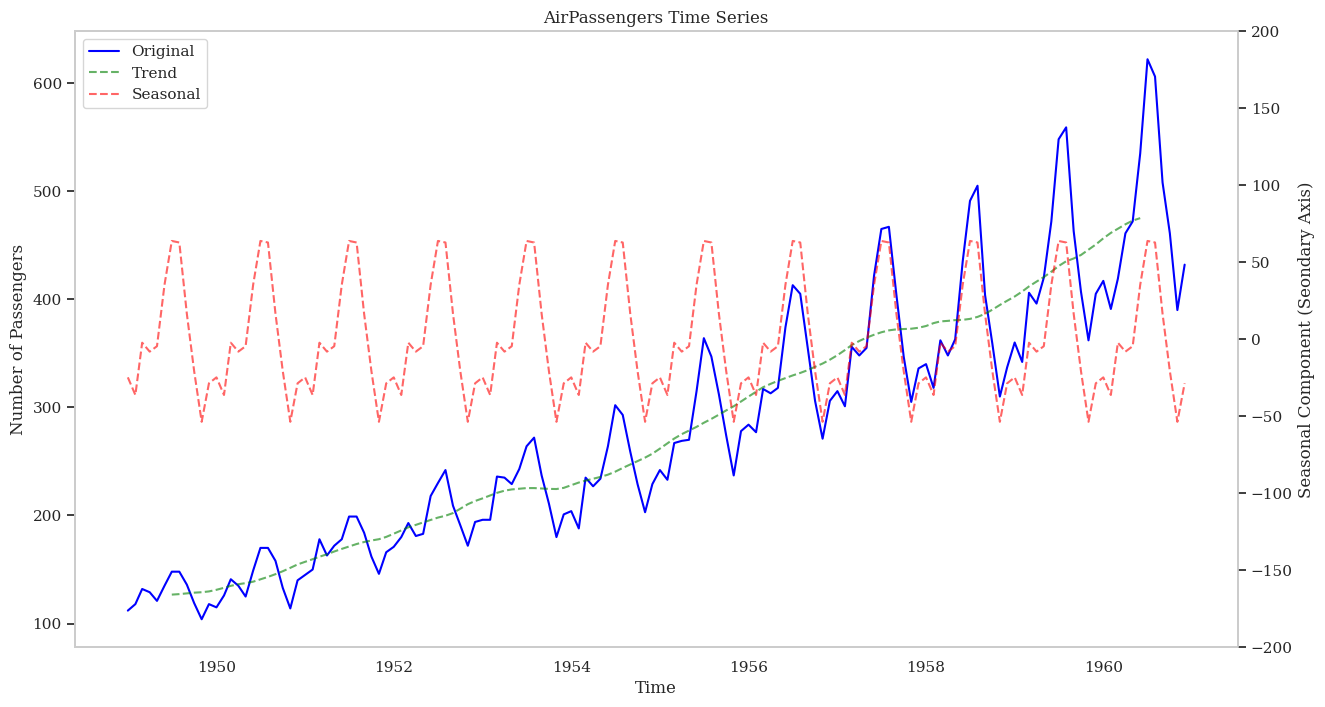

In [3]:
# Plot the original time series with annotations
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(data['Passengers'], label='Original', color='blue')
ax.set_title('AirPassengers Time Series')
ax.set_xlabel('Time')
ax.set_ylabel('Number of Passengers')

# beautify plot with font type
ax.plot(result.trend, label='Trend', color='green', alpha=0.6, linestyle='--')

# add seasonal trend on secondary y-axis
ax2 = ax.twinx()
ax2.plot(result.seasonal, label='Seasonal', color='red', alpha=0.6, linestyle='--')
ax2.set_ylabel('Seasonal Component (Seondary Axis)')

# change seoconday axis range from -100 to 100
ax2.set_ylim(-200, 200)

# add legend for both primary and seconday y-axis together
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

ax2.grid(False)
ax.grid(False)


# Stationarity Test

In [4]:
from statsmodels.tsa.stattools import adfuller

output = adfuller(data['Passengers'])

result = {
        'ADF Statistic': round(output[0],3),
        'p-value': round(output[1],3),
        'Critical Values (1%)': round(output[4]['1%'],3),
        'Critical Values (5%)': round(output[4]['5%'],3),
        'Critical Values (10%)': round(output[4]['10%'],3),}
print(pd.Series(result))

ADF Statistic            0.815
p-value                  0.992
Critical Values (1%)    -3.482
Critical Values (5%)    -2.884
Critical Values (10%)   -2.579
dtype: float64


In [5]:
train_end = '1960-01-01'
data.reset_index(inplace=True)
train_data = data[data['Month'] <= train_end]['Passengers']
test_data = data[data['Month'] > train_end]['Passengers']

print(train_data.shape)

data
print(test_data.shape)

(133,)
(11,)


In [11]:
train_data.to_csv('train_data.csv', index=False)


# Fit the SARIMA Model

order (iterable or iterable of iterables, optional) – The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).

seasonal_order (iterable, optional) – The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. s is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect.


In [6]:
# Find Order
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
Sarimax_model = auto_arima(train_data,
                           start_p=0, start_q=0, 
                           max_p=6, max_q=6, 
                           max_d=12,
                           seasonal=True, 
                           m=12,  # Seasonal period (e.g., 12 for monthly data with yearly seasonality)
                           start_P=0, start_Q=0, 
                           max_P=25, max_Q=25, 
                           d=None, D=None, 
                           max_D=25,
                           trace=True, 
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                           random = True,
                           n_fits = 10,
                           information_criterion = 'aic')
Sarimax_model.summary()



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=912.700, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=907.606, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=908.564, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=906.884, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=907.882, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=908.389, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=908.081, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=907.694, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=910.080, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=908.515, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.308 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  133
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -451.442
Date:                            Sat, 27 Jul 2024   AIC                            906.884
Time:                                    19:07:30   BIC                            912.459
Sample:                                         0   HQIC                           909.148
                                            - 133                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2513      0.089     -2.822      0.005      -0.426      -0.077
sigma2       108.3773     13.168      8.231      0.000      82.569     134.185
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.90   Prob(JB):                         0.77
Heteroskedasticity (H):               1.44   Skew:                            -0.01
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
order = (1,1,0)
seasonal_order = (0, 1, 0, 12)
# define model
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)

In [8]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)
#summary of the model
print(model_fit.summary())

Model Fitting Time: 0.05099296569824219
                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  133
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -451.442
Date:                            Sat, 27 Jul 2024   AIC                            906.884
Time:                                    19:07:35   BIC                            912.459
Sample:                                         0   HQIC                           909.148
                                            - 133                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2513      0.089     -2.822      0.005      -0.426      -0

Text(0, 0.5, 'Error')

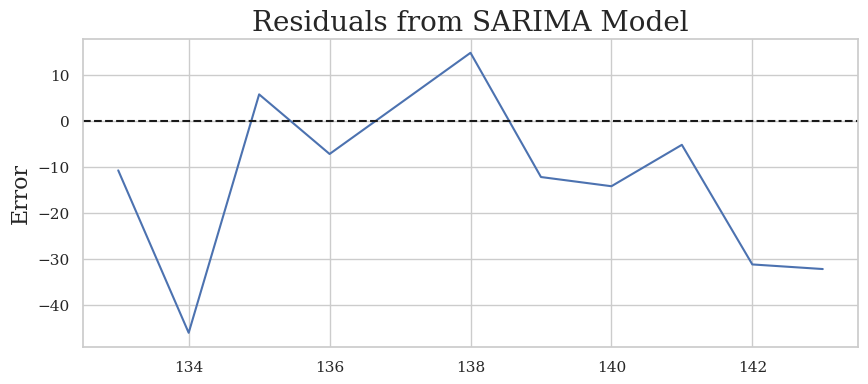

In [9]:
predictions = model_fit.forecast(len(test_data))
predictions 
#get the predictions and residuals
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions
residuals 

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)


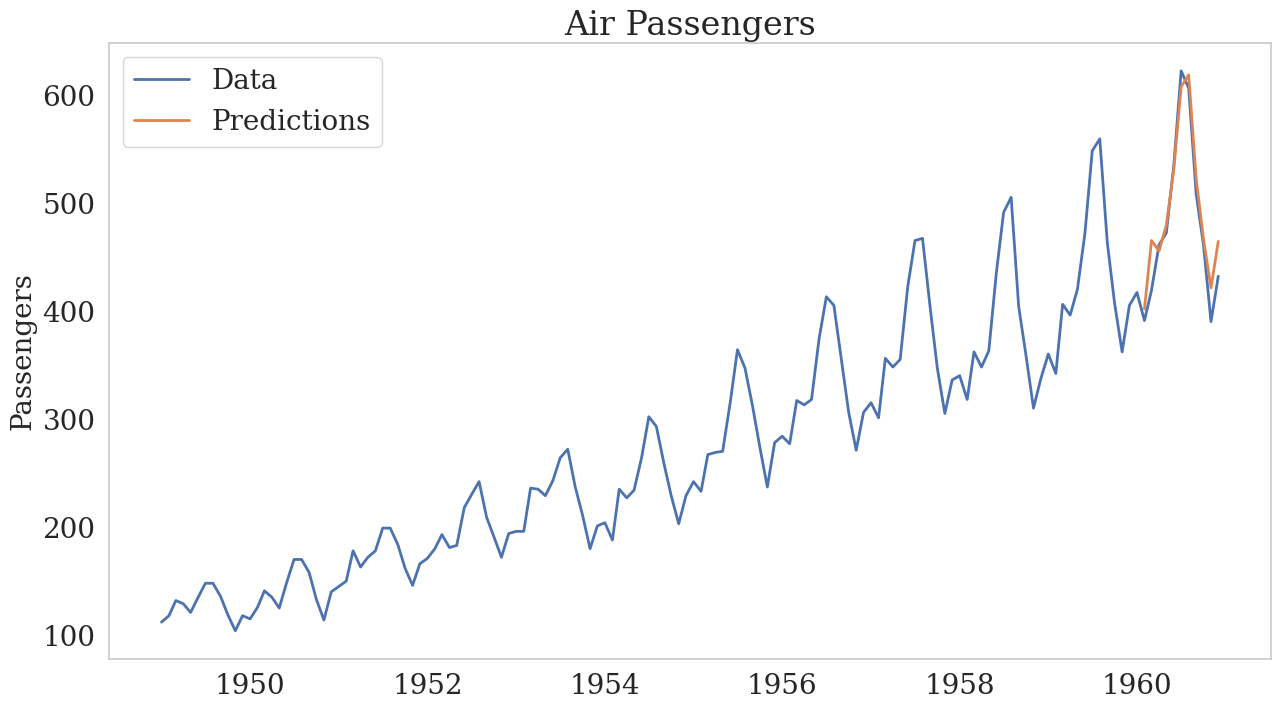

In [14]:
sns.set(style="whitegrid")
plt.rcParams.update({
    'figure.figsize': (14, 10),  # Size of the figure
    'font.size': 20,             # Font size for text elements
    'xtick.labelsize': 20,       # Font size for x-axis tick labels
    'ytick.labelsize': 20,       # Font size for y-axis tick labels
    'axes.labelsize': 20,         # Font size for x and y labels
    'legend.fontsize': 20,         # Font size for the legend
    'font.family': 'serif',         # Font family, can be 'serif', 'sans-serif', 'monospace', etc.
    'legend.title_fontsize': 20,     # Font size for the legend title, if present
    'lines.linewidth': 2.0,          # Default line width for plot lines
    'axes.titlesize': 24            # Font size for the plot title



})
plt.rc('font', family='serif')

plt.figure(figsize=(15,8))

plt.plot(data['Month'], data['Passengers'], label='Data')
plt.plot(data[data['Month'] > train_end]['Month'],predictions)

plt.legend(('Data', 'Predictions'))

plt.title('Air Passengers')
plt.ylabel('Passengers')
plt.grid(False)


# Rolling Prediction

In [49]:
order = (1,1,0)
seasonal_order = (0, 1, 0, 12)

In [48]:
test_data.index

Index([133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143], dtype='int64')

In [59]:
rolling_predictions = test_data.copy()
for train_end_index in test_data.index:
    train_data = data[:train_end_index]['Passengers']
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions[train_end_index] =  int(pred.iloc[0])

In [61]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

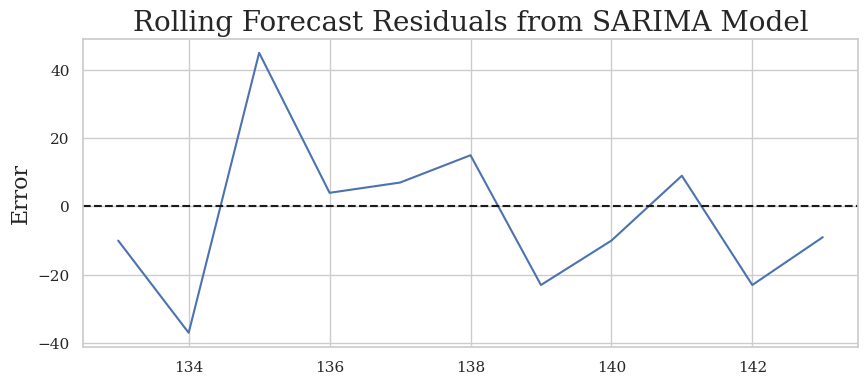

In [62]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Production')

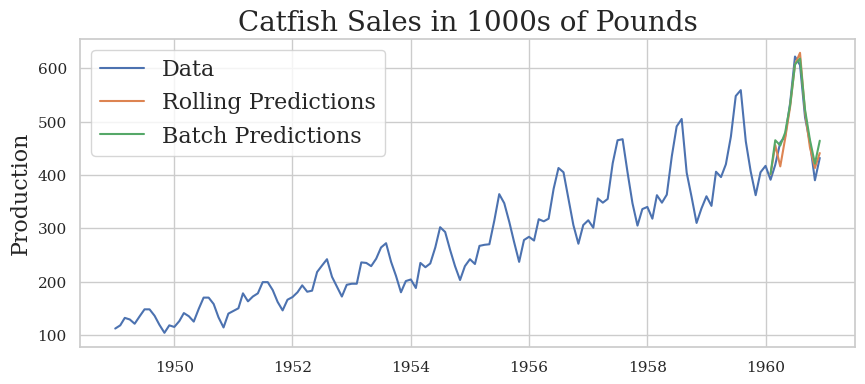

In [63]:
plt.figure(figsize=(10,4))

plt.plot(data['Month'], data['Passengers'], label='Data')
plt.plot(data[data['Month'] > train_end]['Month'],rolling_predictions, label='Rolling Predictions')
plt.plot(data[data['Month'] > train_end]['Month'],predictions, label='Batch Predictions')

plt.legend(('Data', 'Rolling Predictions', 'Batch Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)


In [170]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0381


In [171]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))



Root Mean Squared Error: 1035.7798304383307
